In [7]:
import numpy as np
import imageio.v3 as iio
import imageio.v3 as iio1
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.distance import pdist
from sklearn.metrics import auc, roc_curve
import glob
import os
import math
import torch
import time
from torch.utils.data import Dataset, Subset, DataLoader
import random

In [8]:
images_dir = '/path/to/your/preprocessed/image/tensors/zipfile'
masks_dir = '/path/to/your/preprocessed/image/tensors/zipfile'

In [9]:
class LazyTensorDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir

        self.image_files = [f for f in os.listdir(images_dir) if f.endswith("_image.pt")]
        self.dummy_indices = []
        self.non_dummy_indices = []

        for idx, img_file in enumerate(self.image_files):
            image_id = img_file.split('_')[0]
            mask_file = f"{image_id}_mask.pt"
            mask_path = os.path.join(masks_dir, mask_file)

            if not os.path.exists(mask_path) or torch.load(mask_path, map_location="cpu").sum() == 0:
                self.dummy_indices.append(idx)
            else:
                self.non_dummy_indices.append(idx)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        image_id = img_file.split('_')[0]
        mask_file = f"{image_id}_mask.pt"

        image_tensor = torch.load(os.path.join(self.images_dir, img_file), map_location="cpu")
        mask_path = os.path.join(self.masks_dir, mask_file)

        if os.path.exists(mask_path):
            mask_tensor = torch.load(mask_path, map_location="cpu")
        else:
            mask_tensor = torch.zeros((image_tensor.shape[1], image_tensor.shape[2]), dtype=torch.uint8)

        return {
            "image": image_tensor,
            "ground_truth_mask": mask_tensor,
            "image_id": image_id
        }


In [10]:
def get_ship_subset(images_dir, masks_dir, image_ids):
    dataset = LazyTensorDataset(images_dir, masks_dir)

    # Create a map from image_id to dataset index
    image_id_to_index = {
        img_file.split("_")[0]: idx
        for idx, img_file in enumerate(dataset.image_files)
    }

    # Get indices for the provided image_ids
    selected_indices = [
        image_id_to_index[img_id]
        for img_id in image_ids
        if img_id in image_id_to_index
    ]

    ship_subset = Subset(dataset, selected_indices)

    print(f"Loaded {len(ship_subset)} images based on provided image_ids.")
    return ship_subset


In [32]:
import json

json_imageids_dir = "/path/to/your/json/file/of/image_ids"
with open(json_imageids_dir, "r") as f:
    split_ids = json.load(f)

# since a comparison with SAM-LoRA took place, the imageids used for testing in SAM were used here
image_ids = split_ids("test")

In [33]:
ship_subset = get_ship_subset(images_dir, masks_dir, image_ids)

Loaded 3000 images based on provided image_ids.


In [34]:
target_size = 512  # or 1024
higher_res = False

images_dict_RGB = {}
images_dict_norm = {}
groundtruth_dict = {}

for idx in ship_subset.indices:
    img_file = ship_subset.dataset.image_files[idx]

    inputs = ship_subset.dataset[idx]
    image_tensor = inputs["image"]
    mask_tensor = inputs["ground_truth_mask"]
    image_id = inputs["image_id"]

    image_np = image_tensor.permute(1, 2, 0).numpy().astype(np.float32)
    mask_np = (mask_tensor > 0).squeeze(0).cpu().numpy().astype(np.uint8)

    if higher_res:
        image_np = cv2.resize(image_np, (target_size, target_size), interpolation=cv2.INTER_LINEAR)
        mask_np = cv2.resize(mask_np, (target_size, target_size), interpolation=cv2.INTER_NEAREST)

    mu = image_np.mean(axis=(0, 1))
    image_norm = image_np / mu

    images_dict_RGB[image_id] = image_np
    images_dict_norm[image_id] = image_norm
    groundtruth_dict[image_id] = mask_np

print("Shape of the first image:", list(images_dict_norm.values())[0].shape if images_dict_norm else "No images found")
print("Shape of the first mask:", list(groundtruth_dict.values())[0].shape if groundtruth_dict else "No masks found")

Shape of the first image: (256, 256, 3)
Shape of the first mask: (256, 256)


In [35]:
imageRGBD = iio1.imread('/PATH/TO//ships.png')
imageRGBD = imageRGBD[:, :, :3]
print('image.shape = ', imageRGBD.shape)

d = imageRGBD.shape[-1]
mu = np.mean(imageRGBD.reshape(-1, d), axis=0)
image = imageRGBD / mu

image.shape =  (269, 480, 3)


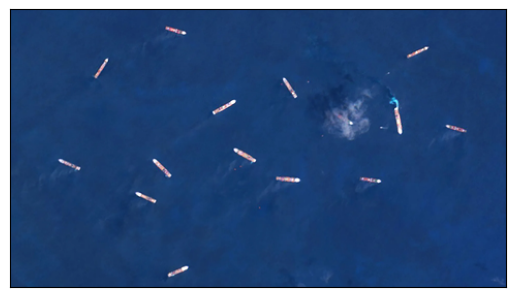

In [36]:
fig = plt.imshow(imageRGBD)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

In [37]:
groundtruthD = iio1.imread('/PATH/TO/ships_groundtruth.png')
groundtruthD = groundtruthD > 0
groundtruthD = groundtruthD.astype(float)
groundtruthD = 1.0 - groundtruthD


print('groundtruth.shape = ', groundtruthD.shape)

groundtruth.shape =  (269, 480, 3)


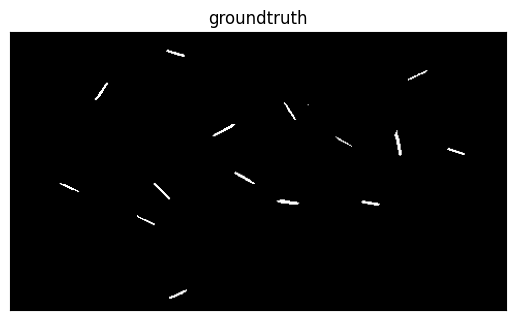

In [38]:
fig = plt.imshow(groundtruthD, cmap='gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('groundtruth')
plt.show()

## FUNCTIONS

In [39]:
def estimateSigma(X, sample_size=5000):
    n_samples = X.shape[0]

    if n_samples * (n_samples - 1) / 2 <= sample_size:
        pairwise_distances = pdist(X, metric='euclidean')
    else:
        idx1 = np.random.choice(n_samples, size=sample_size)
        idx2 = np.random.choice(n_samples, size=sample_size)
        diff = X[idx1] - X[idx2]
        pairwise_distances = np.sqrt(np.sum(diff ** 2, axis=1))

    sigma = max(np.sqrt((np.median(pairwise_distances) + np.mean(pairwise_distances)) / 2.0), 1e-3)

    return sigma

In [40]:
def createMappedImage(image, D, sigma=None):
    d = image.shape[-1]
    X = image.reshape(-1, d)

    if (sigma is None):
        sigma = estimateSigma(X)

    d = image.shape[-1]
    G = np.random.randn(D, D)
    Q, _ = np.linalg.qr(G)
    S = np.diag(np.sqrt(np.random.chisquare(1, size=D)))
    W = np.dot(S, Q)[:, :d] / sigma

    Z = X @ W.T
    mappedImage = Z.reshape(image.shape[0], image.shape[1], -1)

    return mappedImage

In [41]:
class TiledAlgorithm:
    def __init__(self, tile_size, padding, border_type, band_size):
        self.tile_size = tile_size
        self.padding = padding
        self.border_type = border_type
        self.band_size = band_size

    def process(self, source_image):
        # Get image dimensions
        height, width, channels = source_image.shape

        # Calculate number of rows and columns based on tile size
        rows = (height // self.tile_size) + (1 if height % self.tile_size else 0)
        cols = (width // self.tile_size) + (1 if width % self.tile_size else 0)

        tiles = []
        tile_centers = []
        tile_means = []
        tile_covariances = []
        result_image = np.zeros_like(source_image)

        for row_tile in range(rows):
            for col_tile in range(cols):
                # Compute tile start and end positions with band size
                x_start = max(col_tile * self.tile_size - self.band_size, 0)
                y_start = max(row_tile * self.tile_size - self.band_size, 0)
                x_end = min(x_start + self.tile_size + self.band_size, width)
                y_end = min(y_start + self.tile_size + self.band_size, height)

                # Extract the tile and force it to be of fixed size
                src_tile = np.zeros((self.tile_size + self.band_size, self.tile_size + self.band_size, channels), dtype=source_image.dtype)
                self.copySourceTile(source_image, src_tile, (x_start, y_start, x_end, y_end))

                # Compute the center of the tile
                tile_center_x = (x_start + x_end) // 2
                tile_center_y = (y_start + y_end) // 2
                tile_centers.append((tile_center_x, tile_center_y))

                # Reshape tile for mean and covariance calculation
                tile = source_image[y_start:y_end, x_start:x_end]
                tile_reshaped = tile.reshape(-1, channels)
                mu_tile = np.mean(tile_reshaped, axis=0)
                Xtrz = tile_reshaped - mu_tile
                tile_reshaped_area = Xtrz.shape[0]
                cov_tile = (1 / tile_reshaped_area) * np.dot(Xtrz.T, Xtrz) + np.eye(channels) * 1e-16  # Regularization

                # Store the computed values
                tile_means.append(mu_tile)
                tile_covariances.append(cov_tile)
                tiles.append(src_tile)

                # Copy tile to the result image with proper blending
                dst_tile = (col_tile * self.tile_size, row_tile * self.tile_size)
                self.copyTileToResultImage(src_tile, result_image, dst_tile)

        return tiles, tile_centers, tile_means, tile_covariances, result_image

    def copySourceTile(self, src, src_tile, tile):
        """
        Extract a tile from the source image considering padding and boundary constraints,
        ensuring all tiles are the same fixed size.
        """
        x_start, y_start, x_end, y_end = tile
        cropped_tile = src[y_start:y_end, x_start:x_end]

        # Pad the tile if it's smaller than the expected tile size + band size
        top_pad = max(0, (self.tile_size + self.band_size) - cropped_tile.shape[0])
        left_pad = max(0, (self.tile_size + self.band_size) - cropped_tile.shape[1])

        src_tile[:] = cv2.copyMakeBorder(cropped_tile, 0, top_pad, 0, left_pad, self.border_type)

    def copyTileToResultImage(self, tile_image, result_image, result_roi):
        """
        Copy the processed tile to the result image, ensuring smooth blending in overlapping regions.
        """
        x_start, y_start = result_roi
        x_end = min(x_start + self.tile_size, result_image.shape[1])
        y_end = min(y_start + self.tile_size, result_image.shape[0])

        tile_view = tile_image[:y_end - y_start, :x_end - x_start]

        # Blend overlapping regions instead of directly copying
        existing_view = result_image[y_start:y_end, x_start:x_end]
        alpha = 0.5  # Blend factor
        result_image[y_start:y_end, x_start:x_end] = cv2.addWeighted(existing_view, alpha, tile_view, 1 - alpha, 0)

In [42]:
def compute_weighted(means, covariances, tile_centers, image, alpha=0.01):

    height, width, _ = image.shape
    RX_scores = np.zeros((height, width))

    # Create a grid of pixel coordinates (height x width)
    x_indices, y_indices = np.meshgrid(np.arange(width), np.arange(height))  # x, y indices of pixels

    # Compute pixel-to-tile center distances for all tiles
    w_i = np.array([
        np.sqrt((y_indices - tile_center[1]) ** 2 + (x_indices - tile_center[0]) ** 2)
        for tile_center in tile_centers
    ])  # Shape (num_tiles, height, width)

    # Compute the weights for all pixels based on tile distances
    weights = np.exp(-alpha * w_i)  # Shape (num_tiles, height, width)

    # Normalize weights across all tiles for each pixel
    weights_sum = np.sum(weights, axis=0)  # Sum over tile axis, result shape (height, width)

    # Compute Mahalanobis distances for all pixels against all tiles
    for idx, (mean_vec, cov_inv) in enumerate(zip(means, covariances)):
        # Compute pixel-wise Mahalanobis distance for all pixels
        z_hat = image - mean_vec  # Shape (height, width, num_channels)
        d_i_hat = np.sum(z_hat @ cov_inv * z_hat, axis=-1)  # Compute Mahalanobis distance squared
        d_i = np.sqrt(d_i_hat)  # Take square root for final Mahalanobis distances

        RX_scores += (weights[idx] * d_i)  # Weighted sum of Mahalanobis distances

    # Normalize the final RX scores
    RX_scores /= weights_sum  # Normalize by total weight for each pixel

    return RX_scores

## MAIN CODE

In [43]:
tile_size = 45
band_size = tile_size // 2
tot_size = tile_size + band_size
D = 3
padding = 5
border_type = cv2.BORDER_CONSTANT

airbus ship detection challenge dataset

In [44]:
results_dict = {}

# Iterate over the images in the dictionary
for img_idT, imageT in images_dict_norm.items():
    # Process each image
    mappedImageT = createMappedImage(imageT, D)

    n_channelsT = mappedImageT.shape[2]

    # Initialize the algorithm with the desired parameters
    algorithm = TiledAlgorithm(tile_size, padding, border_type, band_size)

    # Process the image to get tiles, tile centers, means, covariances, and result image
    tilesT, tile_centersT, tile_meansT, tile_covariancesT, result_imageT = algorithm.process(mappedImageT)

    # Store the result in the dictionary with the image ID
    results_dict[img_idT] = {
        'mapped_imageT': mappedImageT,
        'tilesT': tilesT,
        'tile_centersT': tile_centersT,
        'tile_meansT': tile_meansT,
        'tile_covariancesT': tile_covariancesT,
        'result_imageT': result_imageT,
    }


In [ ]:
GL_times = {}
count = 0

for img_idT, imageT in images_dict_norm.items():

    starttimeGL =time.time()
    # Compute the weighted LRX scores for the image
    weighted_LRX_scoresT = compute_weighted(
        results_dict[img_idT]['tile_meansT'],
        results_dict[img_idT]['tile_covariancesT'],
        results_dict[img_idT]['tile_centersT'],
        results_dict[img_idT]['mapped_imageT']  # Correct key name
    )
    total_timeGL = time.time() - starttimeGL
    GL_times[img_idT] = total_timeGL

    # Store the weighted LRX scores in the results dictionary
    results_dict[img_idT]['weighted_LRX_scoresT'] = weighted_LRX_scoresT
    count += 1

    print("Done for", count)


In [49]:
def showRXresultT(ax, RX_scores, title, percentileValue=99):
    threshold = np.percentile(RX_scores.flatten(), percentileValue)
    ax.imshow(RX_scores >= threshold, cmap='gray')
    ax.set_title(title, fontsize=10)
    ax.axis('off')

In [50]:
def showRXscoresT(ax, RX_scores, title):
    ax.imshow(RX_scores, cmap='gray')
    ax.set_title(title, fontsize=10)
    ax.axis('off')

In [60]:
# Sample one item
sampled_items = ["0b3e3440b.jpg"]

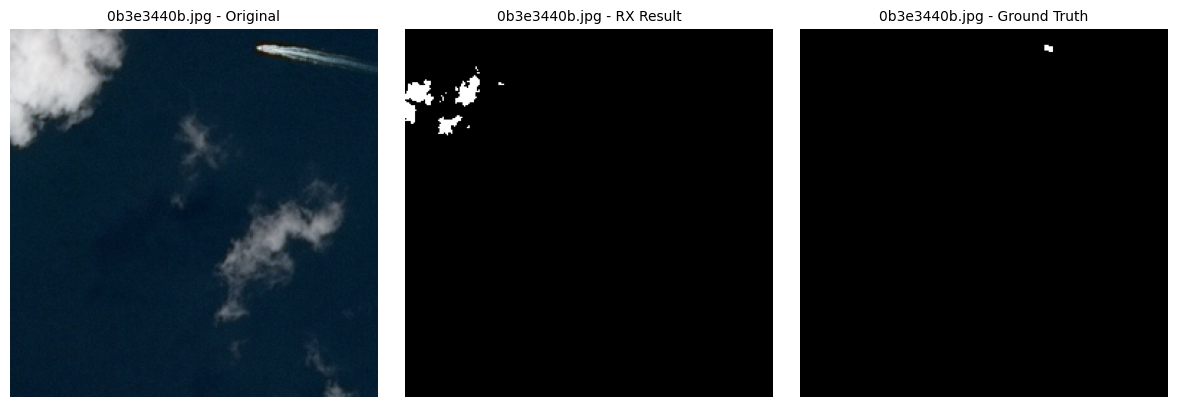

In [61]:
cols = 3   # 3 plots per image (Original, RX Result, Ground Truth)
rows = len(sampled_items)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

if rows == 1:
    axes = np.expand_dims(axes, axis=0)  # handle single-row case

for row_idx, img_idT in enumerate(sampled_items):
    # Original RGB
    axes[row_idx, 0].imshow(images_dict_RGB[img_idT])
    axes[row_idx, 0].set_title(f"{img_idT} - Original", fontsize=10)
    axes[row_idx, 0].axis('off')

    # RX Result
    RX_scores = results_dict[img_idT]['weighted_LRX_scoresT']
    showRXresultT(axes[row_idx, 1], RX_scores, f"{img_idT} - RX Result")

    # Ground Truth Mask
    axes[row_idx, 2].imshow(groundtruth_dict[img_idT], cmap='gray')
    axes[row_idx, 2].set_title(f"{img_idT} - Ground Truth", fontsize=10)
    axes[row_idx, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Sample 13 random keys from the results_dict
sampled_items = random.sample(list(results_dict.items()), 13)

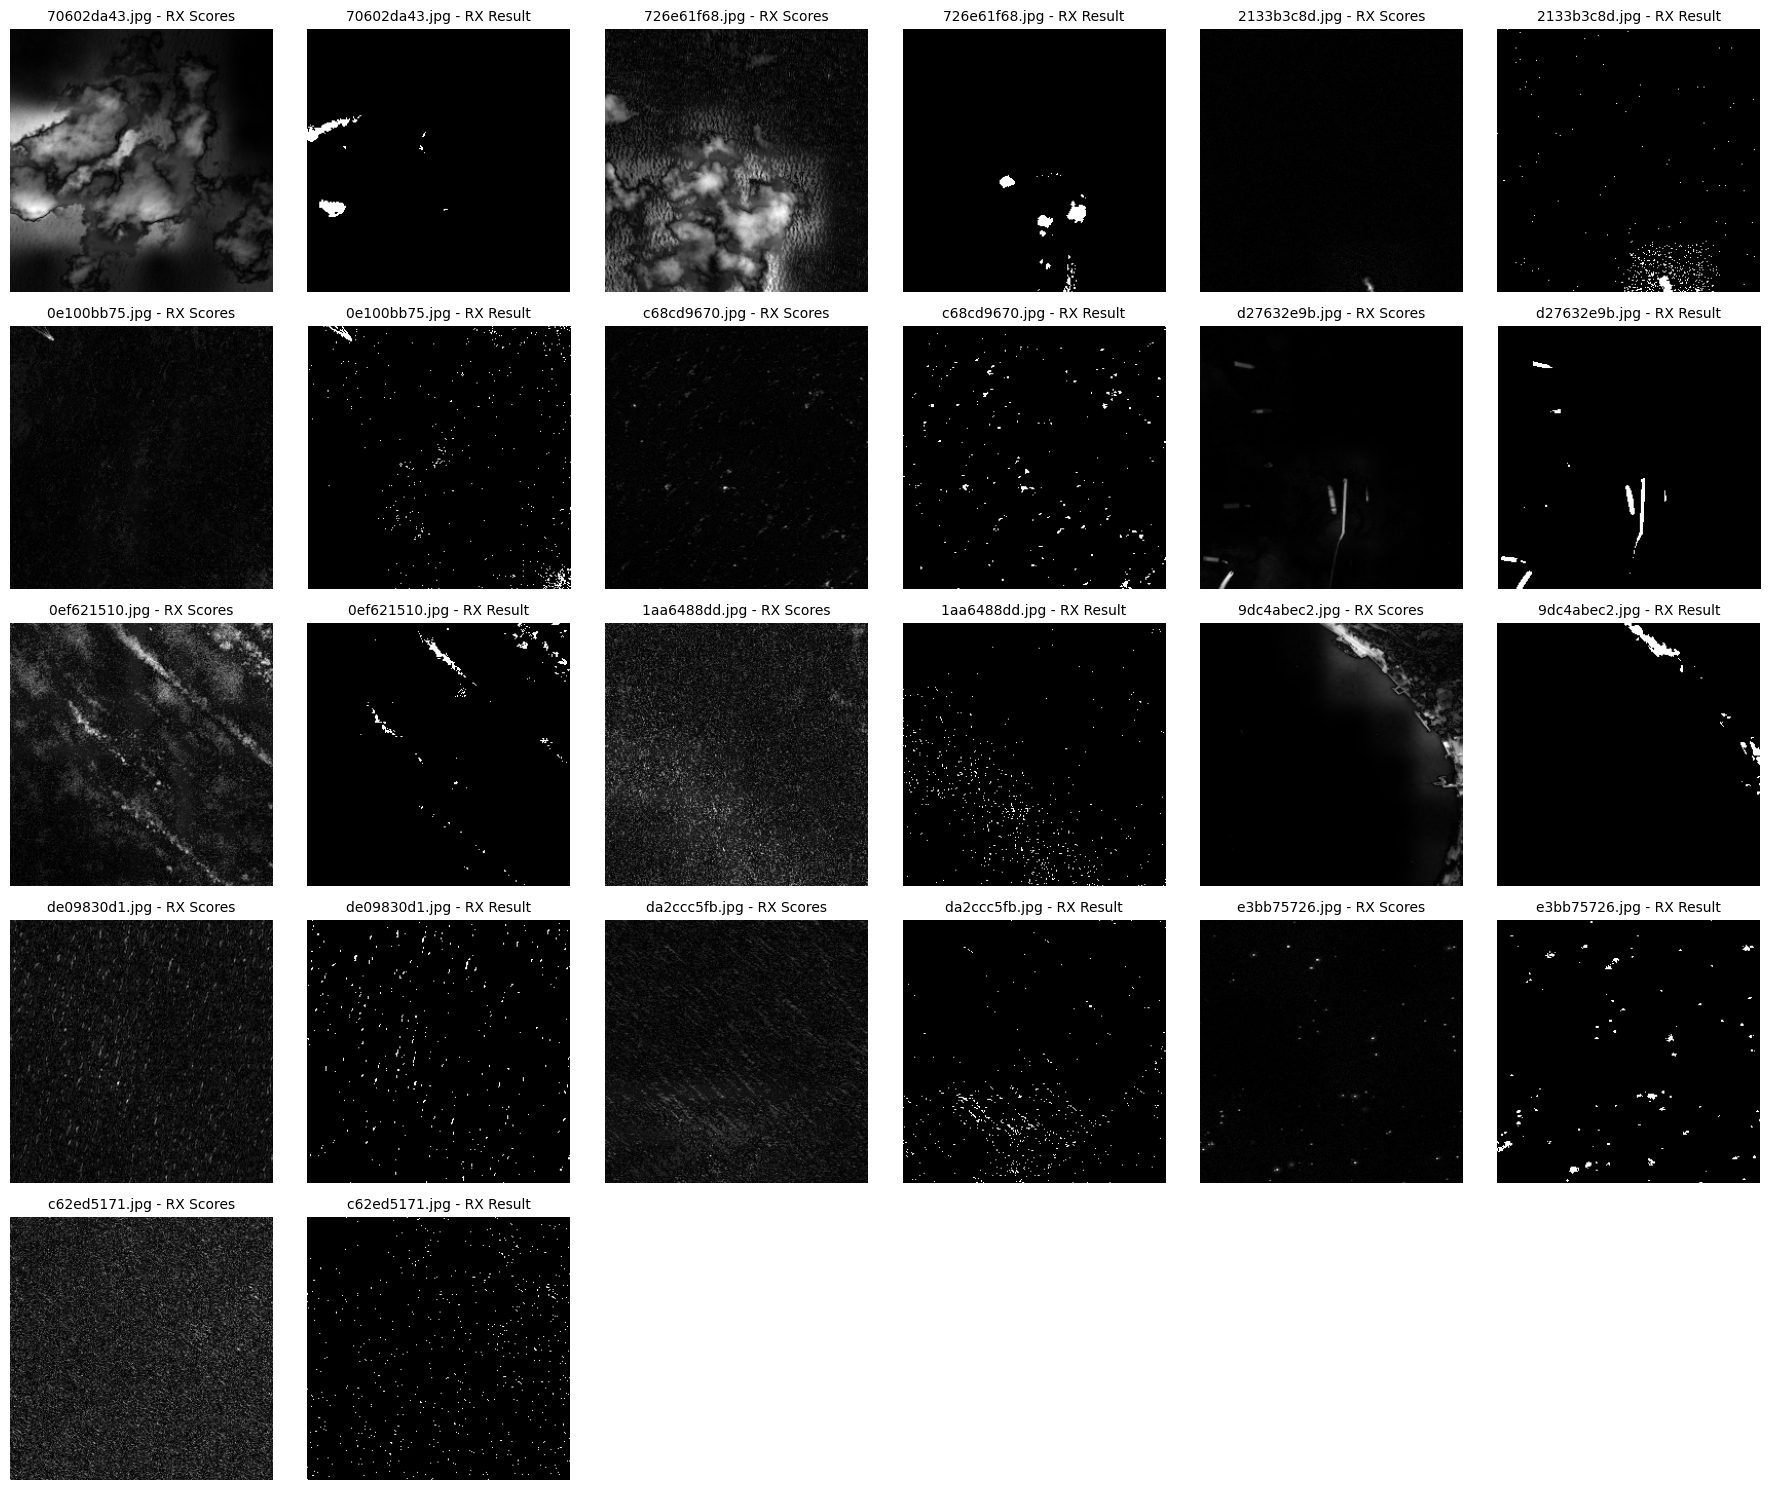

In [ ]:
# Define layout
cols = 6
rows = (13 * 2 + cols - 1) // cols  # 2 plots per image (raw + thresholded)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()

# Plot the selected samples
idx = 0
for img_idT, resultT in sampled_items:
    if idx + 1 >= len(axes):  # Ensure we have space for both subplots
        break
    showRXscoresT(axes[idx], resultT['weighted_LRX_scoresT'], f"{img_idT} - RX Scores")
    idx += 1
    showRXresultT(axes[idx], resultT['weighted_LRX_scoresT'], f"{img_idT} - RX Result")
    idx += 1

# Hide remaining axes
for i in range(idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def draw_grid(image, tile_size, tot_size, dot_spacing = 3):  # Default: black grid lines
    imagecustom = np.copy(image)
    height, width, _ = imagecustom.shape

    for i in range(0, height, tile_size):
        imagecustom[i, :, 0] = 255  # Horizontal lines

    for i in range(0, width, tile_size):
        imagecustom[:, i, 0] = 255 # Vertical lines

    for i in range(0, height, tot_size):
        for j in range(0, width, dot_spacing):  # Add a dot pattern along the line
            imagecustom[i, j, 1] = 255  # Horizontal dotted lines

    for i in range(0, width, tot_size):
        for j in range(0, height, dot_spacing):  # Add a dot pattern along the line
            imagecustom[j, i, 1] = 255  # Vertical dotted lines

    return imagecustom

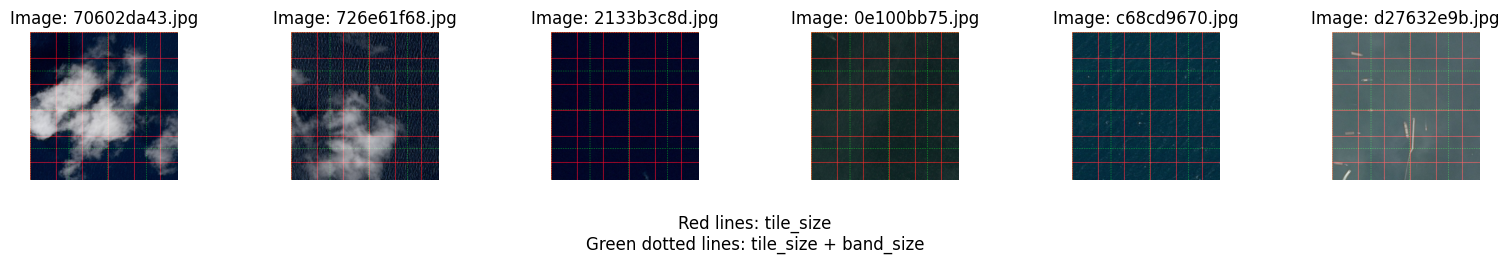

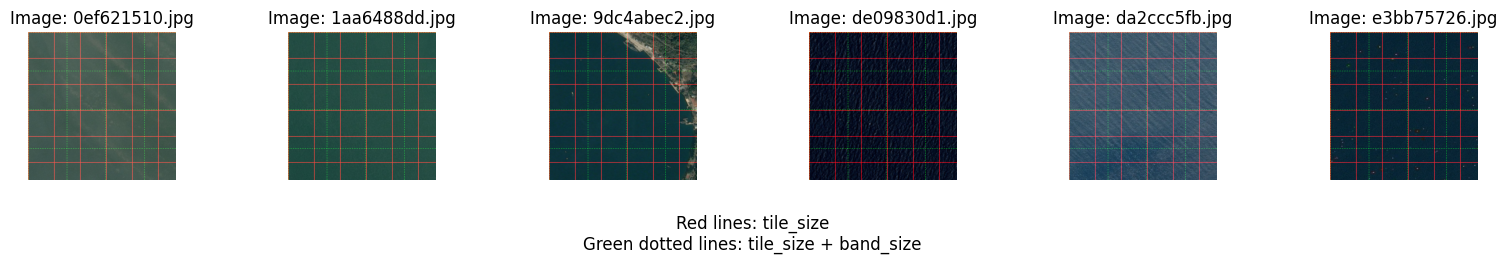

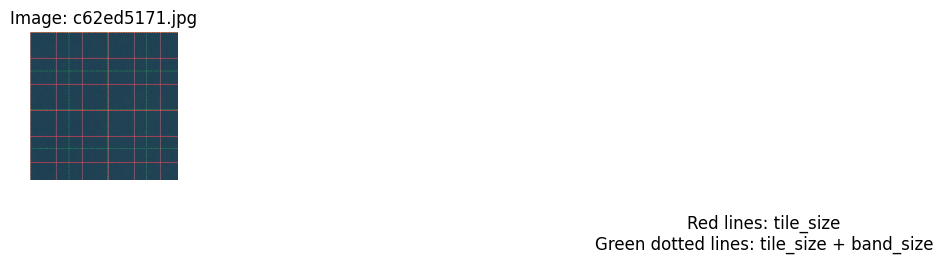

In [ ]:
images_per_row = 6
sampled_ids = [img_id for img_id, _ in sampled_items]  # list of image IDs (e.g., "12345")
n_images = len(sampled_ids)
n_rows = math.ceil(n_images / images_per_row)

for row in range(n_rows):
    plt.figure(figsize=(16, 2))

    for col in range(images_per_row):
        idx = row * images_per_row + col
        if idx >= n_images:
            break

        image_id = sampled_ids[idx]

        imageRGB = images_dict_RGB.get(image_id)

        if imageRGB is None:
            continue  # Skip if image not found

        # Apply the grid lines
        image_with_grid = draw_grid(imageRGB, tile_size, tot_size)

        # Display the image
        plt.subplot(1, images_per_row, col + 1)
        plt.imshow(image_with_grid)
        plt.axis('off')
        plt.title(f'Image: {image_id}')

    plt.figtext(0.5, -0.1, 'Red lines: tile_size\nGreen dotted lines: tile_size + band_size',
                ha='center', va='top', fontsize=12, color='black')

    plt.tight_layout()
    plt.show()

In [ ]:
GL_AUC = {}
for image_id in results_dict:
    if image_id in groundtruth_dict:
        RX_scores = results_dict[image_id]['weighted_LRX_scoresT']
        groundtruth = groundtruth_dict[image_id]

        # Flatten arrays
        y_true = groundtruth.flatten()
        y_scores = RX_scores.flatten()

        if y_true.sum() == 0:
            # No ship present — assign neutral AUC
            AUC_rx = 0.5
            FP_rx, TP_rx = [0, 1], [0, 0]  # Flat ROC
        else:
            FP_rx, TP_rx, _ = roc_curve(y_true, y_scores)
            AUC_rx = auc(FP_rx, TP_rx)

        GL_AUC[image_id] = {
            "auc": AUC_rx,
            "fp": FP_rx,
            "tp": TP_rx
        }

In [ ]:
def showRXperformanceT(fp, tp, auc_val, label, title, ax):
    ax.plot(fp, tp, linewidth=2, label=label + f' AUC = {auc_val:.6f}')
    ax.legend(loc='lower right')
    ax.set_title(title)
    ax.grid()

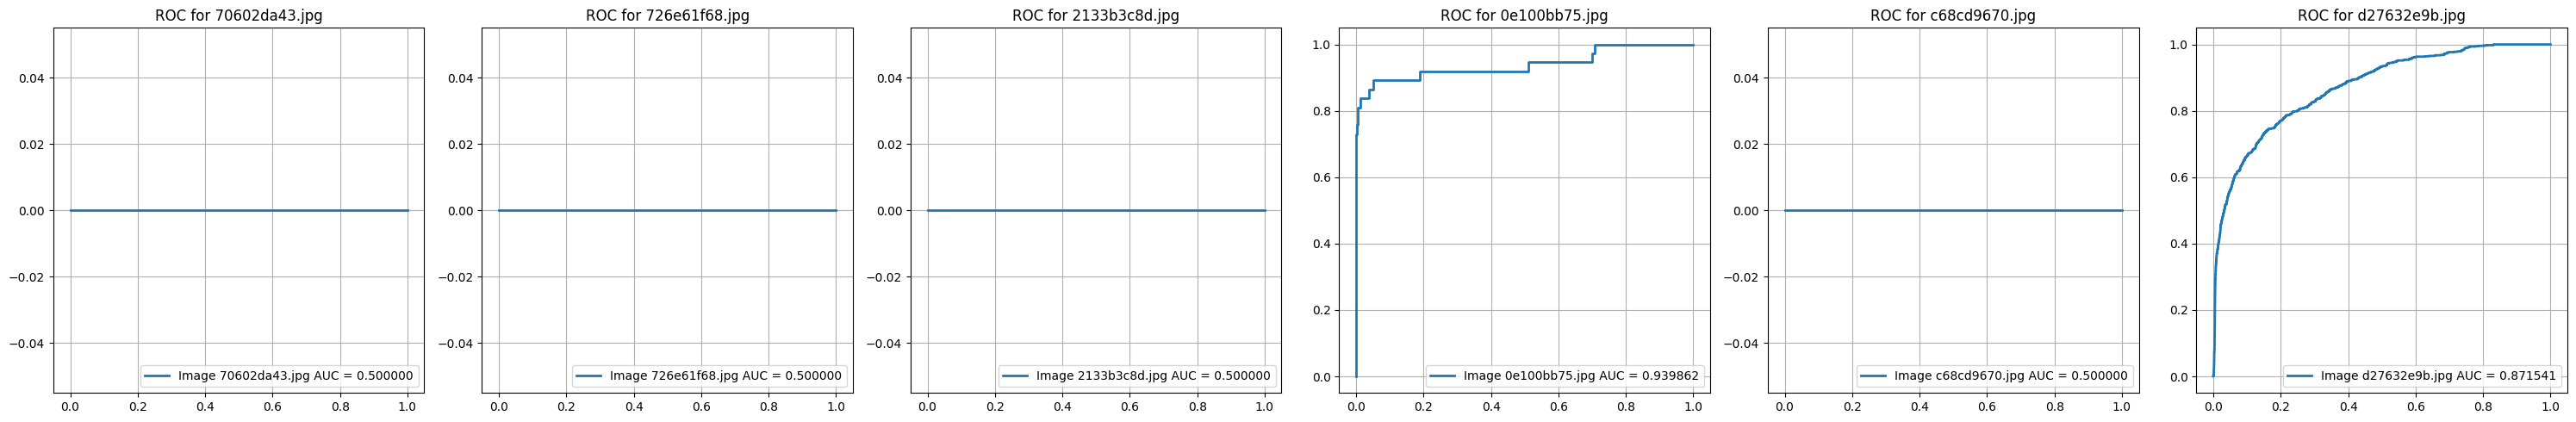

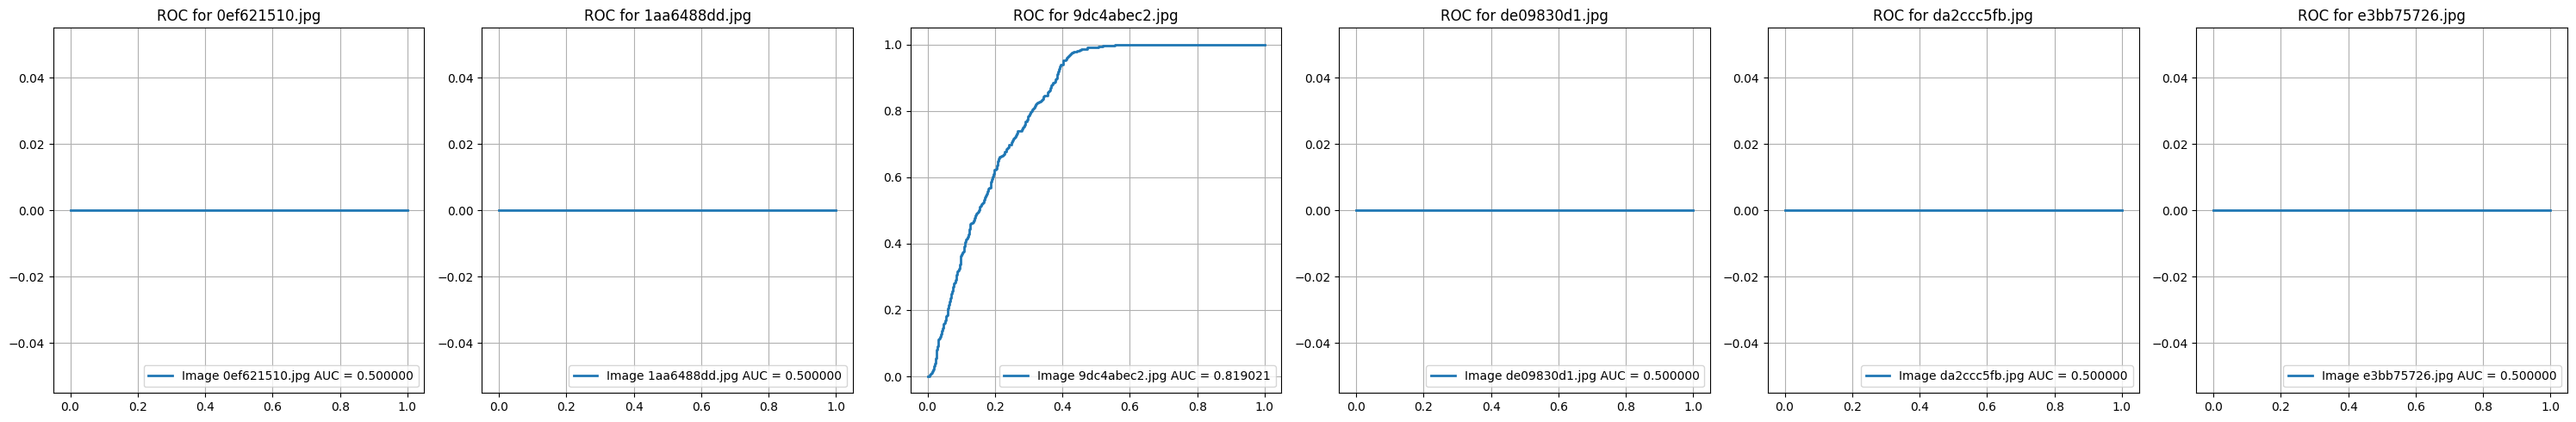

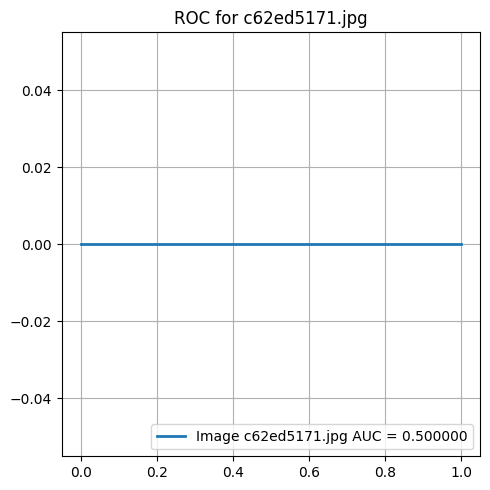

In [ ]:
plots_per_row = 6
sampled_ids = [img_id for img_id, _ in sampled_items]

for i in range(0, len(sampled_ids), plots_per_row):
    batch_ids = sampled_ids[i:i+plots_per_row]
    num_plots = len(batch_ids)

    fig, axes = plt.subplots(1, num_plots, figsize=(num_plots * 5, 5))
    if num_plots == 1:
        axes = [axes]

    for ax, image_id in zip(axes, batch_ids):
        if image_id in GL_AUC:
            auc_data = GL_AUC[image_id]
            showRXperformanceT(
                fp=auc_data["fp"],
                tp=auc_data["tp"],
                auc_val=auc_data["auc"],
                label=f"Image {image_id}",
                title=f"ROC for {image_id}",
                ax=ax
            )
        else:
            ax.set_title(f"Missing Data for {image_id}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()


## TESTING ON SHIPS.PNG IMAGE

In [ ]:
mappedImage = createMappedImage(image, D)

n_channels = image.shape[2]
tile_shape = (tile_size, tile_size, n_channels)

In [ ]:
algorithm = TiledAlgorithm(tile_size, padding, border_type, band_size)
tiles, tile_centers, tile_means, tile_covariances, result_image = algorithm.process(image)
weighted_LRX_scores = compute_weighted(tile_means, tile_covariances, tile_centers, image)

In [ ]:
def showRXscores(RX_scores):
    fig = plt.imshow(RX_scores, cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

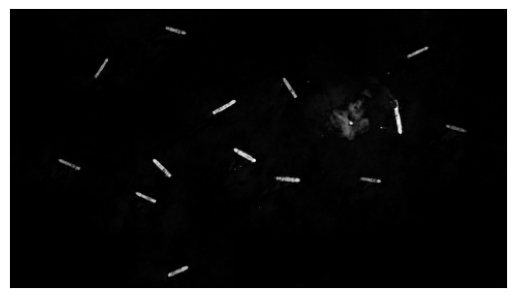

In [ ]:
showRXscores(weighted_LRX_scores)

In [ ]:
def showRXresult(RX_scores, percentileValue=99):
    threshold = np.percentile(RX_scores.flatten(), percentileValue)
    fig = plt.imshow(RX_scores >= threshold, cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

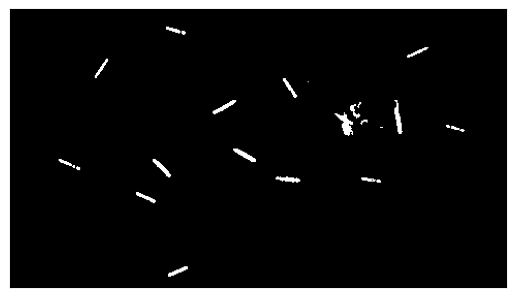

In [ ]:
showRXresult(weighted_LRX_scores)

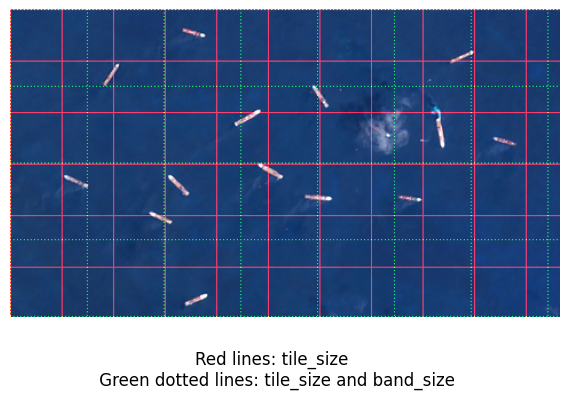

In [ ]:
# Draw the grid (assuming you already have the draw_grid function defined)
image_with_gridD = draw_grid(imageRGBD, tile_size, tot_size)

# Create a figure with increased size
fig = plt.figure(figsize=(8, 4))  # Adjust the size as needed

# Display the image
plt.imshow(image_with_gridD)

# Hide the axes
plt.axis('off')

# Add the custom text with a higher y-position
plt.figtext(0.5, -0.02, f"Red lines: tile_size \n Green dotted lines: tile_size and band_size", ha="center", va="center", fontsize=12)

# Show the plot
plt.show()

In [ ]:
def showRXperformance(groundtruth, RX_scores, label, title):

    if groundtruth.ndim == 3:
        groundtruth = groundtruth[:, :, 0]  # Take a single channel

    FP_rx, TP_rx, T_rx = roc_curve(groundtruth.flatten(), RX_scores.flatten())
    AUC_rx = auc(FP_rx, TP_rx)

    plt.figure(figsize=(8, 6))
    plt.plot(FP_rx, TP_rx, linewidth=2, label=label + ' AUC = ' + str(round(AUC_rx, 6)))
    plt.legend(loc='lower right')
    plt.title(title)
    plt.grid()
    plt.show()

In [ ]:
showRXperformance(groundtruthD, weighted_LRX_scores, 'GLRX', 'Global-Local RX on Real-world Ship Image')

## Local RX Detector Functions

In [ ]:
def local_LRX_detector(image, window_size, guard_size, D, energyPercentile=99.99, lambda_=0, verbose=False):
    mappedImage = createMappedImage(image, D)

    parameters = tuple([energyPercentile])

    return slidingDetector(mappedImage, LRX_detector, window_size, guard_size, lambda_, parameters=parameters, verbose=verbose)

In [ ]:
def createMappedImage(image, D, sigma=None):
    d = image.shape[-1]
    X = image.reshape(-1, d)

    if (sigma is None):
        sigma = estimateSigma(X)

    d = image.shape[-1]
    G = np.random.randn(D, D)
    Q, _ = np.linalg.qr(G)
    S = np.diag(np.sqrt(np.random.chisquare(1, size=D)))
    W = np.dot(S, Q)[:, :d] / sigma

    Z = X @ W.T
    mappedImage = Z.reshape(image.shape[0], image.shape[1], -1)

    return mappedImage

In [ ]:
def createPaddedImage(image, window_size):
    window_radius = window_size // 2
    padded_image = np.pad(image, ((window_radius, window_radius), (window_radius, window_radius), (0, 0)), mode='edge')

    return padded_image

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view

In [ ]:
def slidingDetector(image, detector, window_size, guard_size, lambda_=0, parameters=None, verbose=False):
    padded_image = createPaddedImage(image, window_size)

    n_channels = image.shape[2]
    window_shape = (window_size, window_size, n_channels)
    windows = sliding_window_view(padded_image, window_shape)

    height = windows.shape[0]
    width = windows.shape[1]
    RX_scores = np.zeros((height, width))

    for i in range(height):
        if (verbose and (i % 8) == 0):
            print('.', end='')

        for j in range(width):
            clutter = getClutter(windows, window_size, guard_size, i, j)
            center_pixel = image[i, j, :].reshape(-1, 1)

            RX_scores[i][j] = detector(clutter, center_pixel, lambda_, parameters)

    if (verbose):
        print()

    return RX_scores

In [ ]:
def getClutter(windows, window_size, guard_size, i, j):
    window_radius = window_size // 2
    guard_radius = guard_size // 2
    clutter_radius = window_radius - guard_radius
    window_area = window_size * window_size

    n_channels = windows.shape[-1]
    window = windows[i][j].reshape(window_area, n_channels)

    window2d = window.reshape(window_size, window_size, n_channels)
    r1 = window2d[:clutter_radius, :, :].reshape(-1, n_channels)
    r2 = window2d[clutter_radius:-clutter_radius, :clutter_radius, :].reshape(-1, n_channels)
    r3 = window2d[clutter_radius:-clutter_radius, -clutter_radius:, :].reshape(-1, n_channels)
    r4 = window2d[-clutter_radius:, :, :].reshape(-1, n_channels)
    clutter = np.concatenate((r1, r2, r3, r4), axis=0)

    return clutter

In [ ]:
def LRX_detector(clutter, center_pixel, lambda_, parameters):
    mu = np.mean(clutter, axis=0)

    Xtrz = clutter - mu.reshape(-1, clutter.shape[1])

    clutter_area = Xtrz.shape[0]
    G = (1 / clutter_area) * np.dot(Xtrz.T, Xtrz)
    _, S, Vh = np.linalg.svd(G, full_matrices=False, hermitian=True)

    energyPercentile = parameters[0]
    r = determineRank(S, energyPercentile)
    V = (Vh.T)[:, :r]
    S = S[:r]

    Si_lrx = (1.0 / S).reshape(1, -1)

    z_star = center_pixel - mu.reshape(-1, center_pixel.shape[1])

    v_star = z_star.T @ V

    A_rx = computeRXresponse(v_star, Si_lrx)

    return A_rx

## Global RX Detector Functions

In [ ]:
def getFourierFeatureBasis(D, d, sigma):
    G = np.random.randn(D, D)
    Q, _ = np.linalg.qr(G)
    S = np.diag(np.sqrt(np.random.chisquare(1, size=D)))
    W = np.dot(S, Q)[:, :d] / sigma

    return W

In [ ]:
def mapToZ(X, W, D):
    z_star = np.hstack((np.sin(np.dot(X, W.T)), np.cos(np.dot(X, W.T)))) / np.sqrt(D)

    return z_star

In [ ]:
def determineRank(S, energyPercentile=99.99):
    d = S.shape[0]
    percentile = energyPercentile / 100.0
    logS = np.log(S + 1.0)
    cdf = np.cumsum(logS) / np.sum(logS)

    valid_indices = np.where(np.logical_and(cdf > percentile, logS > 1e-10))[0]

    if len(valid_indices) == 0:
        r = 1  # fallback to minimum rank
    else:
        r = np.min(valid_indices) + 1

    r = max(min(r, d), 1)
    return r

In [ ]:
from sklearn.utils.extmath import randomized_svd

In [ ]:
def computeRXresponse(X, Ci):
    if (Ci.shape[0] == 1):
        if (X.shape[1] == 1):
            response = (X.T * (Ci * X))
        else:
            response = np.sum(np.multiply(X, Ci) * X, axis=1)
    else:
        if (X.shape[1] == 1):
            response = (X.T @ (Ci @ X))
        else:
            response = np.sum((X @ Ci) * X, axis=1)

    if (len(response) == 1):
        return response.item()
    else:
        return response

In [ ]:
def train_LRX(Xtr, D, sigma, r=None, energyPercentile=None, randomizedSVDthreshold=256):
    n = Xtr.shape[0]
    d = Xtr.shape[1]

    W = getFourierFeatureBasis(D, d, sigma)

    Z_star = mapToZ(Xtr, W, D)

    mu = np.mean(Z_star, axis=0)
    Z_star = Z_star - mu.reshape(-1, Z_star.shape[1])

    G = (1 / n) * np.dot(Z_star.T, Z_star)
    if (D < randomizedSVDthreshold):
        _, S, Vh = np.linalg.svd(G, full_matrices=False, hermitian=True)
    else:
        _, S, Vh = randomized_svd(G, n_components=D)

    if (r is None):
        if (energyPercentile is None):
            energyPercentile = 99.0
        r = determineRank(S, energyPercentile)

    V = (Vh.T)[:, :r]
    S = S[:r]

    Si_lrx = (1.0 / S).reshape(1, -1)

    return mu, W, V, Si_lrx

In [ ]:
def inference_LRX(Xts, mu, W, V, Si_lrx):
    Z_star = mapToZ(Xts, W, D) - mu[np.newaxis, :]

    V_star = np.dot(Z_star, V)

    A_lrx = computeRXresponse(V_star, Si_lrx)

    if A_lrx.ndim != 1:
        A_lrx = A_lrx.flatten()

    return A_lrx

In [ ]:
def global_LRX_detector(Xtr, Xts, D, r=None, energyPercentile=None, sigma=None):
    if (sigma is None):
        sigma = estimateSigma(Xtr)

    mu, W, V, Si_lrx = train_LRX(Xtr, D, sigma, r, energyPercentile)

    A_lrx = inference_LRX(Xts, mu, W, V, Si_lrx)

    return A_lrx, Si_lrx

## Main Code of Global and Local RX detector

In [ ]:
window_size = 45
guard_size = 35
lambda_ = 1e-16
Local_D = 8
energyPercentile = 99.99

In [ ]:
seedValue = 1234
np.random.seed(seedValue)
Global_D = 16

In [ ]:
local_LRX_scores = {}
local_times = {}
local_AUC = {}
global_LRX_scores = {}
global_times = {}
global_AUC = {}
count2 = 0

for img_idT, imageT in images_dict_norm.items():
    count2 += 1
    groundtruthY = groundtruth_dict[img_idT]

    # --- Local RX ---
    start_time = time.time()
    Local_scores = local_LRX_detector(
        imageT, window_size, guard_size, Local_D, energyPercentile, lambda_, verbose=True
    )
    total_time = time.time() - start_time
    Local_scores = np.nan_to_num(Local_scores, nan=0.0, posinf=0.0, neginf=0.0)

    local_LRX_scores[img_idT] = Local_scores
    local_times[img_idT] = total_time

    if groundtruthY.sum() == 0:
        AUC_rxL = 0.5
        FP_rxL, TP_rxL = [0, 1], [0, 0]
    else:
        FP_rxL, TP_rxL, _ = roc_curve(groundtruthY.flatten(), Local_scores.flatten())
        AUC_rxL = auc(FP_rxL, TP_rxL)

    local_AUC[img_idT] = AUC_rxL
    print("local Done for", count2)

    # --- Global RX ---
    d = imageT.shape[-1]
    X = imageT.reshape(-1, d)
    start_timeG = time.time()
    A_lrx, Si_lrx = global_LRX_detector(X, X, Global_D)
    total_timeG = time.time() - start_timeG

    expected_size = imageT.shape[0] * imageT.shape[1]

    # Repair malformed global RX scores
    if A_lrx.size != expected_size:
        print(f"⚠️ Detected malformed RX output for {img_idT} (got {A_lrx.shape})")

        if A_lrx.ndim == 2:
            if A_lrx.shape[1] == 1:
                A_lrx = A_lrx.flatten()
            else:
                A_lrx = np.linalg.norm(A_lrx, axis=1)

        if A_lrx.ndim != 1:
            A_lrx = A_lrx.flatten()

        if A_lrx.size < expected_size:
            A_lrx = np.pad(A_lrx, (0, expected_size - A_lrx.size), constant_values=0.0)
        elif A_lrx.size > expected_size:
            A_lrx = A_lrx[:expected_size]

    global_scores = A_lrx.reshape(imageT.shape[0], imageT.shape[1])
    global_LRX_scores[img_idT] = global_scores
    global_times[img_idT] = total_timeG

    if groundtruthY.sum() == 0:
        AUC_rxG = 0.5
        FP_rxG, TP_rxG = [0, 1], [0, 0]
    else:
        FP_rxG, TP_rxG, _ = roc_curve(groundtruthY.flatten(), global_scores.flatten())
        AUC_rxG = auc(FP_rxG, TP_rxG)

    global_AUC[img_idT] = AUC_rxG
    print("global Done for", count2)


In [ ]:
# Define how many columns we want in the figure
cols = 6  # 6 images per row
num_items = len(results_dict)
rows = (num_items * 2 + cols - 1) // cols  # Compute required rows

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

# Flatten the axes array for easier indexing
axes = axes.flatten()

idx = 0
for item1, item2 in zip(global_LRX_scores, sampled_items):
    if idx >= len(axes) - 1:  # Prevent out of bounds
        break
    showRXscoresT(axes[idx], item1, f"{item2} - RX Scores")
    idx += 1
    showRXresultT(axes[idx], item1, f"{item2} - RX Result")
    idx += 1

# Hide any unused subplots
for i in range(idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
plots_per_row = 6
image_ids = sampled_items  # Get the list of image IDs

# Loop through images in chunks of 6
for i in range(0, len(image_ids), plots_per_row):
    batch_ids = image_ids[i:i+plots_per_row]  # Get a batch of 6 image IDs
    num_plots = len(batch_ids)  # Number of plots in the current row

    fig, axes = plt.subplots(1, num_plots, figsize=(num_plots * 5, 5))  # Create subplots
    if num_plots == 1:
        axes = [axes]  # Ensure axes is iterable for a single plot case

    for ax, image_id in zip(axes, batch_ids):
        if image_id in groundtruth_dict and image_id in results_dict:
            image_idx = image_ids.index(image_id)
            # Access RX_scores from the global_LRX_scores list using the image_idx
            RX_scores = global_LRX_scores[image_idx]  # Correctly access the RX scores
            groundtruth = groundtruth_dict[image_id]  # Get ground truth mask

            showRXperformanceT(groundtruth, RX_scores, label=f"Image {image_id}", title=f"ROC for {image_id}", ax=ax)
        else:
            ax.set_title(f"Missing Data for {image_id}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Define how many columns we want in the figure
cols = 6  # 6 images per row
num_items = len(sampled_items)
rows = (num_items * 2 + cols - 1) // cols  # Compute required rows

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

# Flatten the axes array for easier indexing
axes = axes.flatten()

idx = 0
for item1, item2 in zip(local_LRX_scores, sampled_items):
    if idx >= len(axes) - 1:  # Prevent out of bounds
        break
    showRXscoresT(axes[idx], item1, f"{item2} - RX Scores")
    idx += 1
    showRXresultT(axes[idx], item1, f"{item2} - RX Result")
    idx += 1

# Hide any unused subplots
for i in range(idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
plots_per_row = 6
image_ids = sampled_items  # Get the list of image IDs

# Loop through images in chunks of 6
for i in range(0, len(image_ids), plots_per_row):
    batch_ids = image_ids[i:i+plots_per_row]  # Get a batch of 6 image IDs
    num_plots = len(batch_ids)  # Number of plots in the current row

    fig, axes = plt.subplots(1, num_plots, figsize=(num_plots * 5, 5))  # Create subplots
    if num_plots == 1:
        axes = [axes]  # Ensure axes is iterable for a single plot case

    for ax, image_id in zip(axes, batch_ids):
        if image_id in groundtruth_dict and image_id in results_dict:
            image_idx = image_ids.index(image_id)
            # Access RX_scores from the global_LRX_scores list using the image_idx
            RX_scores = local_LRX_scores[image_idx]  # Correctly access the RX scores
            groundtruth = groundtruth_dict[image_id]  # Get ground truth mask

            showRXperformanceT(groundtruth, RX_scores, label=f"Image {image_id}", title=f"ROC for {image_id}", ax=ax)
        else:
            ax.set_title(f"Missing Data for {image_id}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Convert AUC dicts to float values
GL_AUC_values = {k: v["auc"] for k, v in GL_AUC.items()}

results = {
    "Image": list(results_dict.keys()),
    "Local RX Time (s)": [local_times.get(k, 0) for k in results_dict],
    "Global RX Time (s)": [global_times.get(k, 0) for k in results_dict],
    "Global-Local RX Time (s)": [GL_times.get(k, 0) for k in results_dict],
    "Local RX AUC": [local_AUC.get(k, 0) for k in results_dict],
    "Global RX AUC": [global_AUC.get(k, 0) for k in results_dict],
    "Global-Local RX AUC": [GL_AUC_values.get(k, 0) for k in results_dict]
}

In [ ]:
import pandas as pd

df = pd.DataFrame(results)

# Compute averages
df["Average Time (s)"] = df[["Local RX Time (s)", "Global RX Time (s)", "Global-Local RX Time (s)"]].mean(axis=1)
df["Average AUC"] = df[["Local RX AUC", "Global RX AUC", "Global-Local RX AUC"]].mean(axis=1)


In [ ]:
# ✅ Save to CSV
df.to_csv("rx_results.csv", index=False)

print("Saved: rx_results.csv")

Saved: rx_results.csv


## TESTING SHIPS.PNG FOR GLOBAL & LOCAL

GLOBAL

In [ ]:
d = image.shape[-1]
X = image.reshape(-1, d)
Xtr = X
Xts = X

%time   A_lrx, Si_lrx = global_LRX_detector(Xtr, Xts, Global_D)
global_LRX_scores = A_lrx.reshape(image.shape[0], image.shape[1])

print('rank = ', Si_lrx.shape[1])

In [ ]:
showRXscores(global_LRX_scores)

In [ ]:
showRXresult(global_LRX_scores)

In [ ]:
showRXperformance(groundtruthD, global_LRX_scores, 'GRX', 'Global LRX on Real-world Ship Image')

LOCAL

In [ ]:
%time local_LRX_scores = local_LRX_detector(image, window_size, guard_size, LocalD, energyPercentile, lambda_, verbose=True)

In [ ]:
showRXscores(local_LRX_scores)

In [ ]:
showRXresult(local_LRX_scores)

In [ ]:
showRXperformance(groundtruthD, local_LRX_scores, 'LRX', 'Local LRX on Real-world Ship Image')